<center>
<h1><b>Lab 5</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>October 1, 2020</b></h3>
</center>

<hr>

# Nondimensionalization and Scaling

### Dimensionless ODE

$$
\begin{align*}
ml^{2}\ddot{\theta}+\nu l\dot{\theta}+mgl\sin\theta&=Al\cos\omega_{D}t\\
ml\ddot{\theta}+\nu\dot{\theta}+mg\sin\theta&=A\cos\omega_{D}t\\
\\\frac{ml}{mg}\ddot{\theta}+\frac{\nu}{mg}\dot{\theta}+\frac{mg}{mg}\sin\theta&=\frac{A}{mg}\cos\omega_{D}t\\
\\\frac{l}{g}\ddot{\theta}+\frac{\nu}{mg}\dot{\theta}+\sin\theta&=\frac{A}{mg}\cos\omega_{D}t\\
\frac{1}{\omega_{0}^{2}}\ddot{\theta}+\frac{\nu}{mg}\dot{\theta}+\sin\theta&=\hat{A}\cos\omega_{D}t\\
\theta''+\frac{\omega_{0}\nu}{mg}\theta'+\sin\theta&=\hat{A}\cos\hat{\omega}\hat{t}\\
\theta''+\frac{1}{Q}\theta'+\sin\theta&=\hat{A}\cos\hat{\omega}\hat{t}\\
\end{align*}$$

### Dimensionless Energy

$$
\begin{align*}
E&=mgl\left(1-\cos\theta\right)+\frac{1}{2}ml^{2}\omega^{2}\\
&=ml\left(g\left(1-\cos\theta\right)+\frac{1}{2}l\omega^{2}\right)\\
&=\frac{mg^{2}}{\omega_{0}^{2}}\left(1-\cos\theta+\frac{1}{2}\left(\frac{\omega}{\omega_{0}}\right)^{2}\right)\\
&=mgl\left(1-\cos\theta+\frac{1}{2}\hat{\omega}^2\right)\\
&\rightarrow E=1-\cos\theta+\frac{1}{2}\hat{\omega}^2\\
\end{align*}$$

<hr>

### Imports

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
from scipy.integrate import solve_ivp

### Global Constants

In [2]:
_phase_cut = 0  # Poincare Phase
_n = 10
_N = 10000  # Poincare Section Sample Size

_A = 1.5  # Driving 'force' amplitude
_Q = 2.0  # Quality factor
_O = 2.0 / 3.0  # CHaracteristic frequency

_theta0  = 0.2  # initial angle wrt to vertical [rad]
_dtheta0  = 0  # initial angular velocity [rad/s]

### Support Functions

In [3]:
def df_nonlinear_pendulum(t, x, dx, zeta, w0, A, wd):
    return -2 * zeta * w0 * dx - w0 ** 2 * np.sin(x) + A * np.sin(wd * t)


def dsolve(f, t, y0, dy0):
    t = np.asarray(t)
    y0 = np.asarray(y0)
    
    y = np.zeros((np.size(t), np.size(y0)))
    dy = np.zeros((np.size(t), np.size(dy0)))
    y[0] = y0
    dy[0] = dy0

    for i in range(np.size(t)-1):    
        dy[i+1] = dy[i] + f(t[i], y[i], dy[i]) * (t[i + 1] - t[i])
        y[i+1] = y[i] + dy[i + 1] * (t[i + 1] - t[i])
    return y, dy


def create_poincare(N=_N, state0=(_theta0, _dtheta0), Q=_Q, A=_A, O=_O, phase_cut=_phase_cut, sectioning_freq=_O):
    theta0, dtheta0 = state0  # unpack
    dt = 2 * np.pi / sectioning_freq
    t_i = (2 * np.pi + phase_cut) / sectioning_freq
    t_f = (2 * np.pi * N + phase_cut) / sectioning_freq  # stop after an integer multiple of the driving frequency plus the phase offset

    df = lambda t, y : np.asarray([y[1], - y[1] / Q - np.sin(y[0]) + A * np.sin(O * t)])
    sol = solve_ivp(df, [0, t_f], [theta0, dtheta0], t_eval=np.arange(t_i, t_f, dt))#, method=VelocityVerlet)
    
    t = sol.t
    theta, omega = sol.y  # unpack
    theta = np.mod(theta + np.pi, 2 * np.pi) - np.pi  # Constrain theta to [-pi, pi]

    energy = 1 - np.cos(theta) + 0.5 * omega ** 2
    return t, theta, omega, energy


def create_phase(N=_n, n=_N, state0=(_theta0, _dtheta0), Q=_Q, A=_A, O=_O, phase_cut=_phase_cut):
    theta0, dtheta0 = state0  # unpack
    t_i = (2 * np.pi + phase_cut) / O
    t_f = (2 * np.pi * N + phase_cut) / O  # stop after an integer multiple of the driving frequency plus the phase offset

    df = lambda t, y : np.asarray([y[1], - y[1] / Q - np.sin(y[0]) + A * np.sin(O * t)])
    sol = solve_ivp(df, [0, t_f], [theta0, dtheta0], t_eval=np.linspace(t_i, t_f, n))#, method=VelocityVerlet)
    
    t = sol.t
    theta, omega = sol.y  # unpack
    theta = np.mod(theta + np.pi, 2 * np.pi) - np.pi  # Constrain theta to [-pi, pi]

    energy = 1 - np.cos(theta) + 0.5 * omega ** 2
    return t, theta, omega, energy

# Problem 1

In [13]:
# Q=1.24500  # Critical point to period doubling
# Q=1.34870  # Period-1 to period-2
# Q=1.37003  # Period-2 to period-4
# Q=1.37458  # Period-4 to period-8
# Q=1.37555  # Period-8 to period-16
# Q=1.37575  # Period-16 to period-32

# Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8 = 1.24,1.25,1.34,1.35,1.9,2.0,2.1,2.2 
Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8 = 2.0,2.1,2.11,2.12,2.13,1.4,1.41,1.42
t11, theta11, omega11, energy11 = create_poincare(Q=Q1)
t12, theta12, omega12, energy12 = create_poincare(Q=Q2)
t13, theta13, omega13, energy13 = create_poincare(Q=Q3)
t14, theta14, omega14, energy14 = create_poincare(Q=Q4)
t15, theta15, omega15, energy15 = create_poincare(Q=Q5)
t16, theta16, omega16, energy16 = create_poincare(Q=Q6)
t17, theta17, omega17, energy17 = create_poincare(Q=Q7) 
t18, theta18, omega18, energy18 = create_poincare(Q=Q8) 

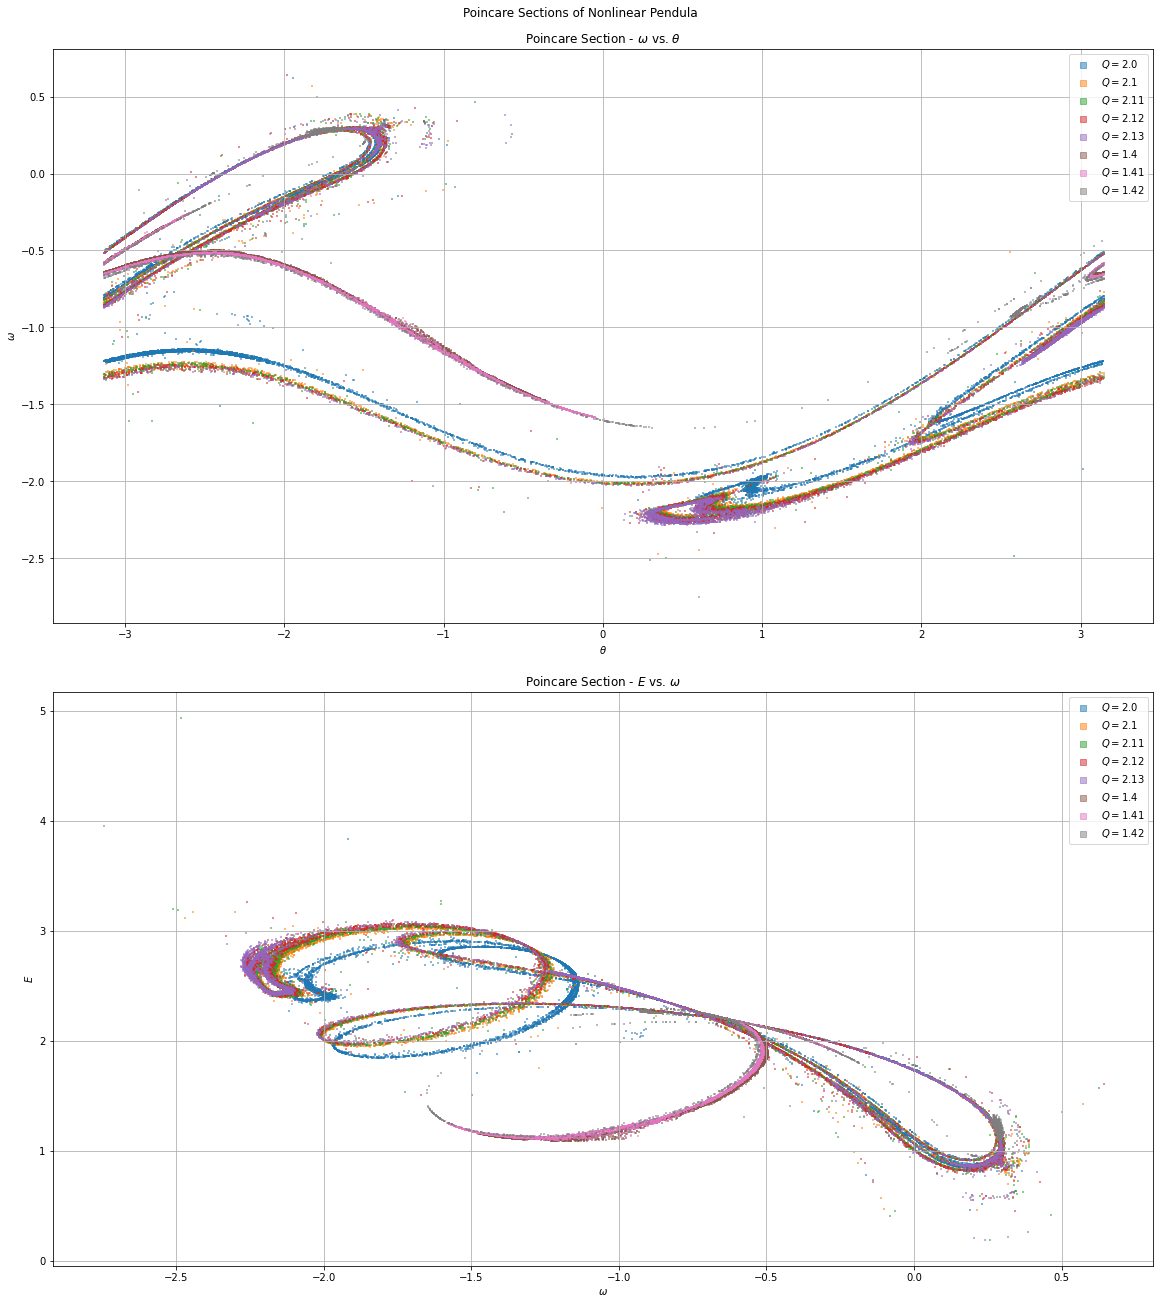

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(16,18), constrained_layout=True)
fig.suptitle(r'Poincare Sections of Nonlinear Pendula')

ax[0].scatter(theta11,  omega11, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q1}$')
ax[1].scatter(omega11, energy11, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q1}$')
ax[0].scatter(theta12,  omega12, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q2}$')
ax[1].scatter(omega12, energy12, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q2}$')
ax[0].scatter(theta13,  omega13, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q3}$')
ax[1].scatter(omega13, energy13, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q3}$')
ax[0].scatter(theta14,  omega14, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q4}$')
ax[1].scatter(omega14, energy14, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q4}$')
ax[0].scatter(theta15,  omega15, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q5}$')
ax[1].scatter(omega15, energy15, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q5}$')
ax[0].scatter(theta16,  omega16, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q6}$')
ax[1].scatter(omega16, energy16, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q6}$')
ax[0].scatter(theta17,  omega17, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q7}$')
ax[1].scatter(omega17, energy17, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q7}$')
ax[0].scatter(theta18,  omega18, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q8}$')
ax[1].scatter(omega18, energy18, s = 1, marker=',', alpha=0.5, label=fr'$Q = {Q8}$')

ax[0].set_title(r'Poincare Section - $\omega$ vs. $\theta$')
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"$\omega$")
ax[0].legend()
ax[0].grid()

ax[1].set_title(r'Poincare Section - $E$ vs. $\omega$')
ax[1].set_xlabel(r"$\omega$")
ax[1].set_ylabel(r"$E$")
ax[1].legend()
ax[1].grid()

for _ax in ax:
    lgnd = _ax.legend(scatterpoints=1, fontsize=10)
    for handle in lgnd.legendHandles:
        handle._sizes = [30]

plt.savefig('problem1.png', dpi=600)
# plt.show()

# Problem 2

In [15]:
t21, theta21, omega21, energy21 = create_poincare(state0=(np.pi/4, 0))
t22, theta22, omega22, energy22 = create_poincare(state0=(np.pi/4, np.pi/4))

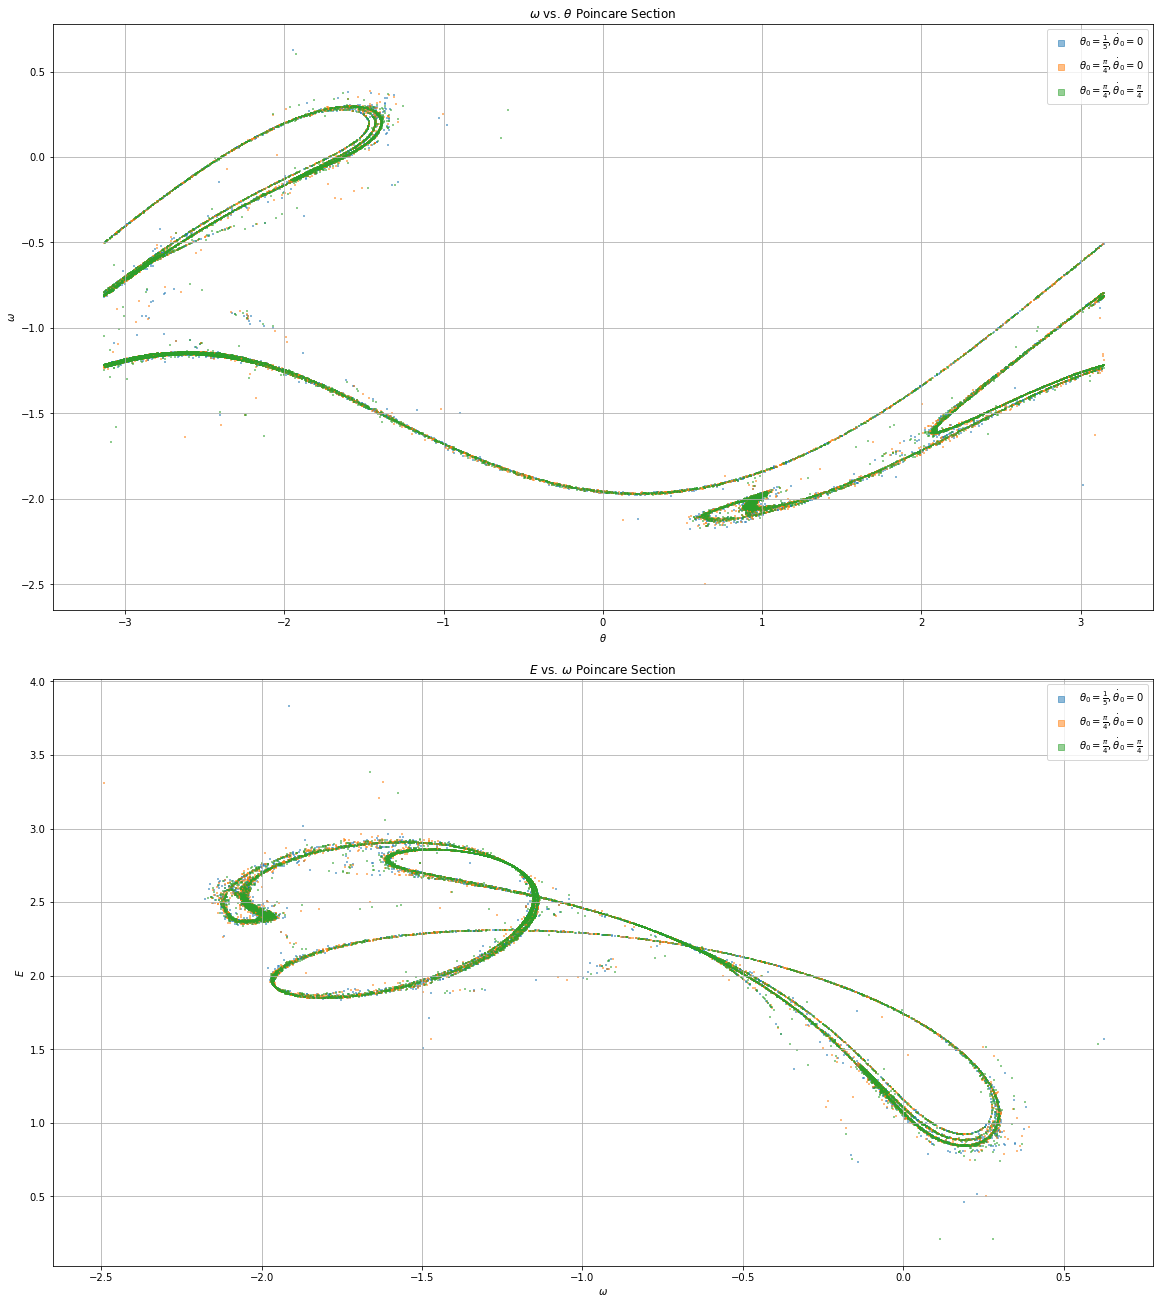

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(16,18), constrained_layout=True)

ax[0].set_title(r'$\omega$ vs. $\theta$ Poincare Section')
ax[0].scatter(theta11, omega11, s=1, marker=',', alpha=0.5, label=r'$\theta_0=\frac{1}{5},   \dot{\theta}_0=0$')
ax[0].scatter(theta21, omega21, s=1, marker=',', alpha=0.5, label=r'$\theta_0=\frac{\pi}{4}, \dot{\theta}_0=0$')
ax[0].scatter(theta22, omega22, s=1, marker=',', alpha=0.5, label=r'$\theta_0=\frac{\pi}{4}, \dot{\theta}_0=\frac{\pi}{4}$')
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"$\omega$")
ax[0].grid()
lgnd0 = ax[0].legend(scatterpoints=1, fontsize=10)
for handle in lgnd0.legendHandles:
    handle._sizes = [30]

ax[1].set_title(r'$E$ vs. $\omega$ Poincare Section')
ax[1].scatter(omega11, energy11, s=1, marker=',', alpha=0.5, label=r'$\theta_0=\frac{1}{5},   \dot{\theta}_0=0$')
ax[1].scatter(omega21, energy21, s=1, marker=',', alpha=0.5, label=r'$\theta_0=\frac{\pi}{4}, \dot{\theta}_0=0$')
ax[1].scatter(omega22, energy22, s=1, marker=',', alpha=0.5, label=r'$\theta_0=\frac{\pi}{4}, \dot{\theta}_0=\frac{\pi}{4}$')
ax[1].set_xlabel(r"$\omega$")
ax[1].set_ylabel(r"$E$")
ax[1].grid()
lgnd1 = ax[1].legend(scatterpoints=1, fontsize=10)
for handle in lgnd1.legendHandles:
    handle._sizes = [30]

plt.savefig('problem2.png', dpi=600)
# plt.show()

It's easy to see that although the green plot is more refined and dense compared to the other two, the overall shape and form remain the same.

# Problem 3

In [17]:
t31, theta31, omega31, energy31 = create_poincare(phase_cut=np.pi/2)
t32, theta32, omega32, energy32 = create_poincare(phase_cut=np.pi)
t33, theta33, omega33, energy33 = create_poincare(phase_cut=37*np.pi/180)

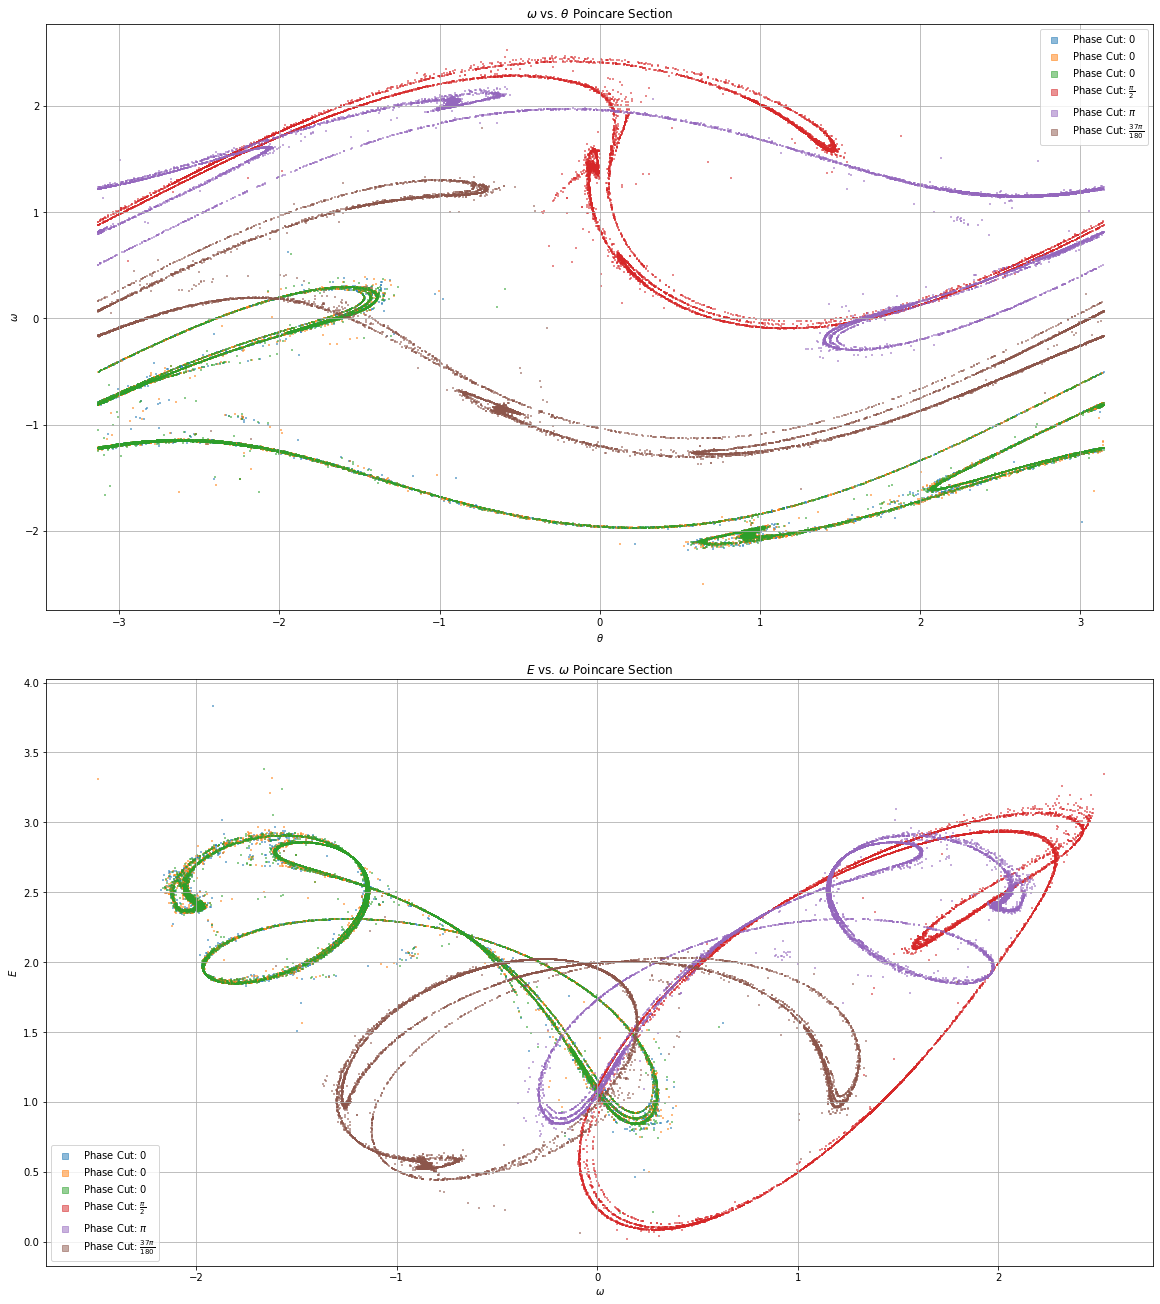

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(16,18), constrained_layout=True)

ax[0].set_title(r'$\omega$ vs. $\theta$ Poincare Section')
ax[0].scatter(theta11, omega11, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $0$')
ax[0].scatter(theta21, omega21, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $0$')
ax[0].scatter(theta22, omega22, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $0$')
ax[0].scatter(theta31, omega31, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $\frac{\pi}{2}$')
ax[0].scatter(theta32, omega32, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $\pi$')
ax[0].scatter(theta33, omega33, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $\frac{37\pi}{180}$')
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"$\omega$")
ax[0].grid()
lgnd0 = ax[0].legend(scatterpoints=1, fontsize=10)
for handle in lgnd0.legendHandles:
    handle._sizes = [30]

ax[1].set_title(r'$E$ vs. $\omega$ Poincare Section')
ax[1].scatter(omega11, energy11, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $0$')
ax[1].scatter(omega21, energy21, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $0$')
ax[1].scatter(omega22, energy22, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $0$')
ax[1].scatter(omega31, energy31, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $\frac{\pi}{2}$')
ax[1].scatter(omega32, energy32, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $\pi$')
ax[1].scatter(omega33, energy33, s=1, marker=',', alpha=0.5, label=r'Phase Cut: $\frac{37\pi}{180}$')
ax[1].set_xlabel(r"$\omega$")
ax[1].set_ylabel(r"$E$")
ax[1].grid()
lgnd1 = ax[1].legend(scatterpoints=1, fontsize=10)
for handle in lgnd1.legendHandles:
    handle._sizes = [30]

plt.savefig('problem3.png', dpi=600)
# plt.show()

In this case, the Poincare sections remain resolved, however, they appear to morph in phase space while keeping some resemblance of their original form.

# Problem 4

In [19]:
t41, theta41, omega41, energy41 = create_poincare(sectioning_freq=np.sqrt(np.pi/2)*_O)
t42, theta42, omega42, energy42 = create_poincare(sectioning_freq=np.sqrt(np.e)*_O)

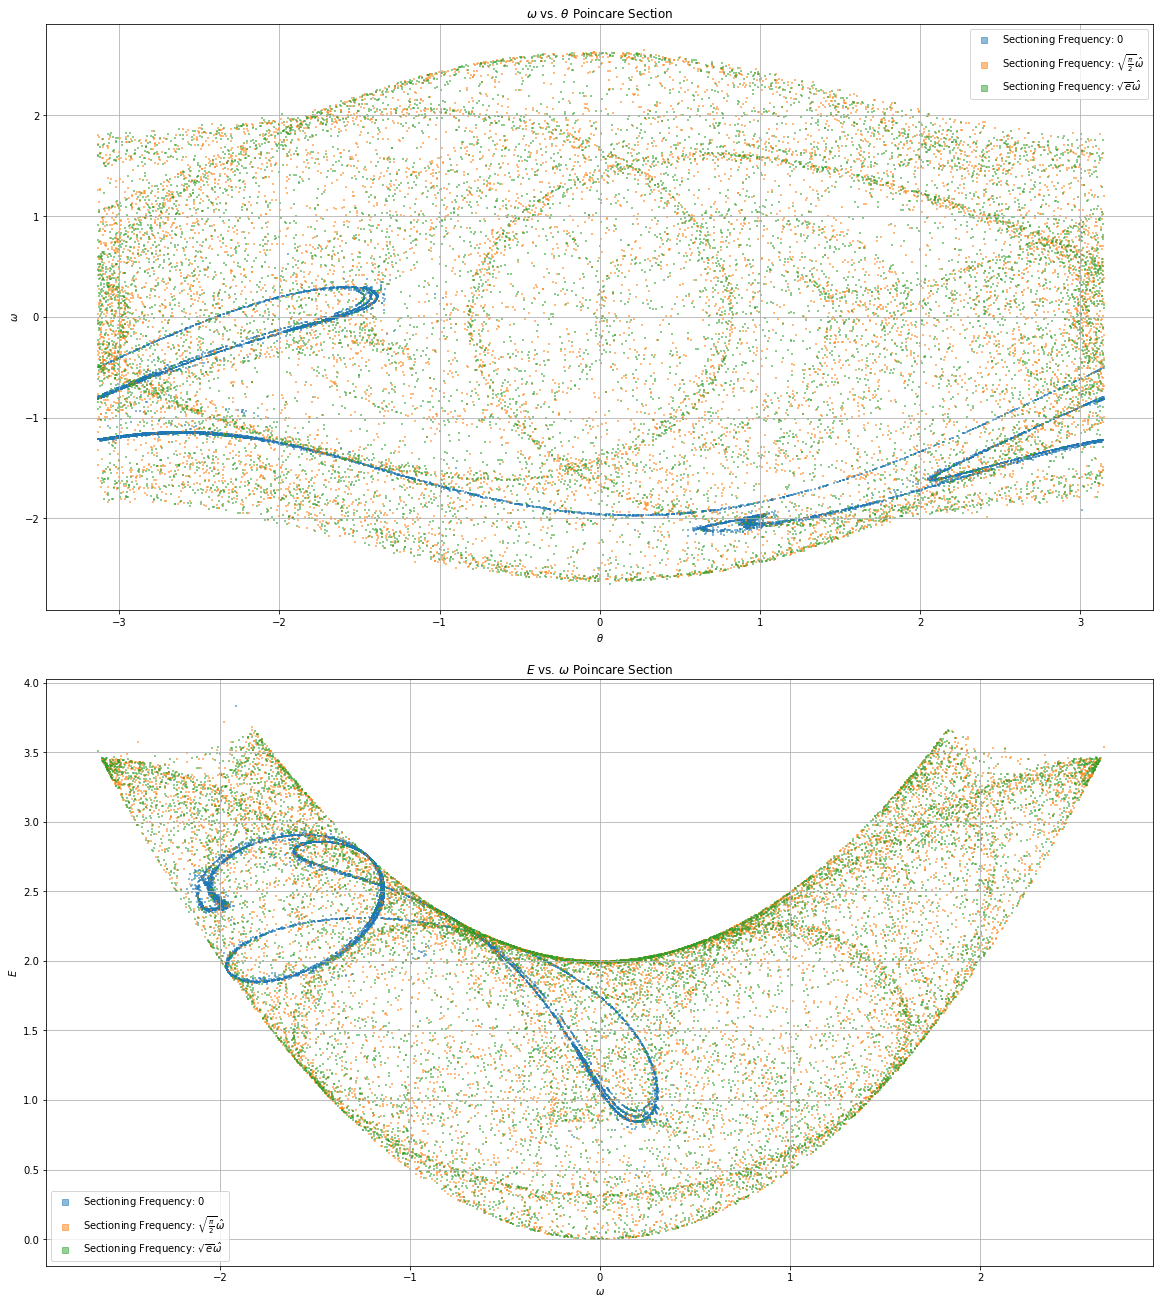

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(16,18), constrained_layout=True)

ax[0].set_title(r'$\omega$ vs. $\theta$ Poincare Section')
ax[0].scatter(theta11, omega11, s=1, marker=',', alpha=0.5, label=r'Sectioning Frequency: $0$')
ax[0].scatter(theta41, omega41, s=1, marker=',', alpha=0.5, label=r'Sectioning Frequency: $\sqrt{\frac{\pi}{2}}\hat{\omega}$')
ax[0].scatter(theta42, omega42, s=1, marker=',', alpha=0.5, label=r'Sectioning Frequency: $\sqrt{e}\hat{\omega}$')
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"$\omega$")
ax[0].grid()
lgnd0 = ax[0].legend(scatterpoints=1, fontsize=10)
for handle in lgnd0.legendHandles:
    handle._sizes = [30]

ax[1].set_title(r'$E$ vs. $\omega$ Poincare Section')
ax[1].scatter(omega11, energy11, s=1, marker=',', alpha=0.5, label=r'Sectioning Frequency: $0$')
ax[1].scatter(omega41, energy41, s=1, marker=',', alpha=0.5, label=r'Sectioning Frequency: $\sqrt{\frac{\pi}{2}}\hat{\omega}$')
ax[1].scatter(omega42, energy42, s=1, marker=',', alpha=0.5, label=r'Sectioning Frequency: $\sqrt{e}\hat{\omega}$')
ax[1].set_xlabel(r"$\omega$")
ax[1].set_ylabel(r"$E$")
ax[1].grid()
lgnd1 = ax[1].legend(scatterpoints=1, fontsize=10)
for handle in lgnd1.legendHandles:
    handle._sizes = [30]

plt.savefig('problem4.png', dpi=600)
# plt.show()

Here we can see the significance of sampling the phase space at rational multiples of the driving frequency. For irrational multiples, there is some kind of structure apparent, but it's ultimately ratiher randomly distributed throughout this region. However, for a rational multiple, a vastly different structure appears very clearly